In [76]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [77]:
csv_file = "./climate.csv"
df = pd.read_csv(csv_file, sep=',')
data = df.values
data
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [78]:
# Chuyển đổi cột Date Time thành định dạng datetime
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

# Chọn các cột số để chuẩn hóa
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

Chuan hoa du lieu mean = 0, std = 1

In [79]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

Chuan hoa va tach du lieu huan luyen

In [80]:
# Tính toán chỉ số chia tách dữ liệu
train_split = int(0.75 * len(df))

# Chuẩn hóa dữ liệu
data = normalize(df[numeric_cols].values, train_split)

# Chia tách dữ liệu thành tập huấn luyện và tập kiểm tra
train_data = data[:train_split]
val_data = data[train_split:]

# Nếu bạn muốn lưu lại các chỉ số của Date Time
train_dates = df['Date Time'][:train_split].values
val_dates = df['Date Time'][train_split:].values

Xac dinh phuong thuc du bao

In [81]:

def create_dataset(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:(i + timesteps), :-1])  # Tất cả các cột trừ cột cuối cùng (giả định cột cuối là nhãn)
        y.append(data[i + timesteps, -1])      # Cột cuối là nhãn
    return np.array(X), np.array(y)

# Số bước thời gian bạn muốn xem xét
timesteps = 10

# Tạo tập dữ liệu cho mô hình
X_train, y_train = create_dataset(train_data, timesteps)
X_val, y_val = create_dataset(val_data, timesteps)

# Kiểm tra kích thước dữ liệu
print("X_train shape:", X_train.shape)  # Nên là (số mẫu, timesteps, số đặc trưng)
print("y_train shape:", y_train.shape)  # Nên là (số mẫu, )


X_train shape: (315403, 10, 13)
y_train shape: (315403,)


In [82]:


model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(timesteps, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Thêm dropout
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))  # Thêm dropout
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [83]:
# Định nghĩa các callback
es_callback = EarlyStopping(
    monitor='val_loss', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-6
)

modelckpt_callback = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min'
)

In [84]:
# Huấn luyện mô hình
epochs = 20  
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[es_callback, modelckpt_callback],
)


Epoch 1/10
1233/1233 [==============================] - 13s 9ms/step - loss: 0.8175 - val_loss: 30312.7266
Epoch 2/10
  15/1233 [..............................] - ETA: 9s - loss: 0.8308

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1233/1233 [==============================] - 11s 9ms/step - loss: 0.7778 - val_loss: 50069.6953
Epoch 3/10
1233/1233 [==============================] - 11s 9ms/step - loss: 0.7560 - val_loss: 10512.4893
Epoch 4/10
1233/1233 [==============================] - 11s 9ms/step - loss: 0.7409 - val_loss: 21037.8809
Epoch 5/10
1233/1233 [==============================] - 11s 9ms/step - loss: 0.7299 - val_loss: 3556.0945
Epoch 6/10
1233/1233 [==============================] - 11s 9ms/step - loss: 0.7217 - val_loss: 7852.8945
Epoch 7/10
1233/1233 [==============================] - 12s 9ms/step - loss: 0.7141 - val_loss: 5568.5381
Epoch 8/10
1233/1233 [==============================] - 12s 9ms/step - loss: 0.7071 - val_loss: 47179.4219
Epoch 9/10
1233/1233 [==============================] - 11s 9ms/step - loss: 0.7025 - val_loss: 10775.3945
Epoch 10/10
1233/1233 [==============================] - 11s 9ms/step - loss: 0.6975 - val_loss: 28738.6973


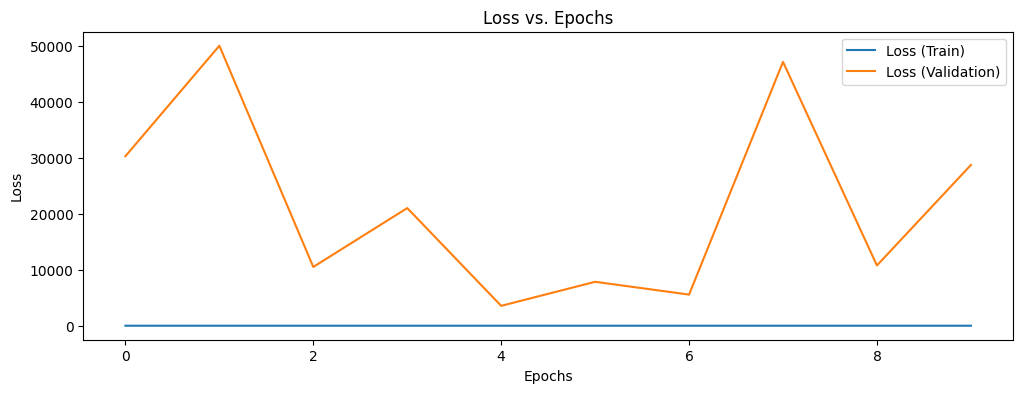

In [85]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()